In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels
import sys

from statistics import mean

In [2]:
df = pd.read_csv('duplicate_counts.csv')
df.columns = ['no', 'id', 'flags', 'ref', 'for_pos', 'qual', 'cigar', 'paired', 'rev_pos', 'length', 'for_count', 'rev_count']
df.head()

,no,id,flags,ref,for_pos,qual,cigar,paired,rev_pos,length,for_count,rev_count
0,0,SRR10199716.585733,1187,U00096.3,3340,60,138M,=,3713,507,6,6
1,1,SRR10199716.199418,1187,U00096.3,3340,60,138M,=,3713,507,6,6
2,2,SRR10199716.111533,1187,U00096.3,3340,60,138M,=,3713,507,6,6
3,3,SRR10199716.240847,1187,U00096.3,3340,60,130M8S,=,3713,507,6,6
4,4,SRR10199716.219410,163,U00096.3,3340,60,138M,=,3713,507,6,6


### clean up the data to remove reads with incorrect pairings; remove the reverse instances of pairs afterwards

Create a 'counts' column by grouping the 'id' column.

In [3]:
df['abs_length'] = df['length'].abs()
df = df.loc[df['abs_length'] < 5000]
df.reset_index(inplace=True, drop=True)
# df['with_adapt'] = df['abs_length'] + 0
df['counts'] = df.groupby(['id'])['paired'].transform('count')

Separate reads into dataframe for those with > 2 counts and those with exactly 2 counts.

In [4]:
tmp_df = df[df['counts'] > 2]
tmp_df.reset_index(inplace=True, drop=True)
df = df[df['counts'] == 2]
df.reset_index(inplace=True, drop=True)

We expect the 'tmp_df' reads to contain correctly paired reads and erroneous pairs. Remove irregular pairings by finding read lengths that have no matches. Concatenate the tmp_df to the overall, correct df.

In [5]:
for_removal = []

for i in range(tmp_df.shape[0]):
    very_tmp = tmp_df[tmp_df['id'] == tmp_df.iloc[i]['id']]
    if very_tmp[very_tmp['abs_length'] == tmp_df.iloc[i]['abs_length']].shape[0] != 2:
        for_removal.append(i)
        
tmp_df.drop(for_removal, inplace=True)
df = pd.concat([df, tmp_df], axis=0)

Remove redundant instances of reverse reads.

In [6]:
df.reset_index(inplace=True, drop=True)
df = df[df['length'] > 0]

Create lists of unique forward and reverse read map positions.

Iterate through each position list, and, using the defined 'window', look for other reads that map to very nearby positions (+/- window). If a nearby position has more mappings, it is likely that it holds the correct mapping start site. A new column 'for_mark'/'rev_mark' stores the current position, or the position assumed to be correct.

In [7]:
for_ls = df['for_pos'].unique().tolist()
rev_ls = df['rev_pos'].unique().tolist()

window = 10

mark_dt = {}
for i in for_ls:
    mark = i
    target = df[df['for_pos'] == i].shape[0]
    for j in range(i - window, i + window):
        if df[df['for_pos'] == j].shape[0] > target:
            target = df[df['for_pos'] == j].shape[0]
            mark = j
    mark_dt[i] = mark
df['for_mark'] = df['for_pos'].map(mark_dt)


mark_dt = {}
for i in rev_ls:
    mark = i
    target = df[df['rev_pos'] == i].shape[0]
    for j in range(i - window, i + window):
        if df[df['rev_pos'] == j].shape[0] > target:
            target = df[df['rev_pos'] == j].shape[0]
            mark = j
    mark_dt[i] = mark
df['rev_mark'] = df['rev_pos'].map(mark_dt)

Assuming that all reads will contain mismappings at a similar rate, remove reads that don't begin at expected sites.

In [8]:
df = df[(df['for_pos'] == df['for_mark']) & (df['rev_pos'] == df['rev_mark'])]
df

,no,id,flags,ref,for_pos,qual,cigar,paired,rev_pos,length,for_count,rev_count,abs_length,counts,for_mark,rev_mark
0,0,SRR10199716.585733,1187,U00096.3,3340,60,138M,=,3713,507,6,6,507,2,3340,3713
1,1,SRR10199716.199418,1187,U00096.3,3340,60,138M,=,3713,507,6,6,507,2,3340,3713
2,2,SRR10199716.111533,1187,U00096.3,3340,60,138M,=,3713,507,6,6,507,2,3340,3713
3,3,SRR10199716.240847,1187,U00096.3,3340,60,130M8S,=,3713,507,6,6,507,2,3340,3713
4,4,SRR10199716.219410,163,U00096.3,3340,60,138M,=,3713,507,6,6,507,2,3340,3713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86526,86547,SRR10199716.652277,1123,U00096.3,4634943,60,134M,=,4635048,243,33,31,243,2,4634943,4635048
86527,86548,SRR10199716.118008,1123,U00096.3,4634943,60,134M,=,4635048,243,33,31,243,2,4634943,4635048
86564,52219,SRR10199716.606725,99,U00096.3,3094094,49,75S59M,=,3094106,145,1,2,145,3,3094094,3094106
86566,65689,SRR10199716.654148,99,U00096.3,3879587,60,12S95M27S,=,3879614,95,2,2,95,3,3879587,3879614


Create a unique identifer for each read based on shared forward and reverse positions.

In [9]:
df['for_mark'] = df['for_mark'].map(str)
df['rev_mark'] = df['rev_mark'].map(str)
df['unique_id'] = df['for_mark'] + '_' + df['rev_mark']

In [10]:
length_dt = {i: [] for i in df['abs_length'].unique().tolist()}

loci_ls = df['unique_id'].unique().tolist()

In [11]:
window = 10

final_df = pd.DataFrame()
avgs_dt = {}
mark_dt = {}

for i in loci_ls:
    tmp_df = df[(df['unique_id'] == i)]
    tmp_dt = tmp_df['abs_length'].value_counts().to_frame().to_dict()['abs_length']
    target = max(tmp_dt, key=tmp_dt.get)
    tmp_df = tmp_df[tmp_df['abs_length'].between(target - window, target + window)]
    tmp_df['abs_length'] = target
    final_df = pd.concat([final_df, tmp_df], axis=0)
    if target in avgs_dt:
        avgs_dt[target].append(tmp_df.shape[0])
    else:
        avgs_dt[target] = [tmp_df.shape[0]]

In [12]:
min_count = 2

final_df['counts'] = final_df.groupby(['unique_id'])['paired'].transform('count')
final_df = final_df[final_df['counts'] > min_count]
final_df

,no,id,flags,ref,for_pos,qual,cigar,paired,rev_pos,length,for_count,rev_count,abs_length,counts,for_mark,rev_mark,unique_id
0,0,SRR10199716.585733,1187,U00096.3,3340,60,138M,=,3713,507,6,6,507,6,3340,3713,3340_3713
1,1,SRR10199716.199418,1187,U00096.3,3340,60,138M,=,3713,507,6,6,507,6,3340,3713,3340_3713
2,2,SRR10199716.111533,1187,U00096.3,3340,60,138M,=,3713,507,6,6,507,6,3340,3713,3340_3713
3,3,SRR10199716.240847,1187,U00096.3,3340,60,130M8S,=,3713,507,6,6,507,6,3340,3713,3340_3713
4,4,SRR10199716.219410,163,U00096.3,3340,60,138M,=,3713,507,6,6,507,6,3340,3713,3340_3713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86522,86543,SRR10199716.399502,1123,U00096.3,4634943,60,134M,=,4635048,243,33,31,243,29,4634943,4635048,4634943_4635048
86523,86544,SRR10199716.167750,1123,U00096.3,4634943,60,134M,=,4635048,243,33,31,243,29,4634943,4635048,4634943_4635048
86524,86545,SRR10199716.59475,1123,U00096.3,4634943,60,134M,=,4635048,243,33,31,243,29,4634943,4635048,4634943_4635048
86526,86547,SRR10199716.652277,1123,U00096.3,4634943,60,134M,=,4635048,243,33,31,243,29,4634943,4635048,4634943_4635048


### distribution of read depths vs. fragment length

/usr/local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


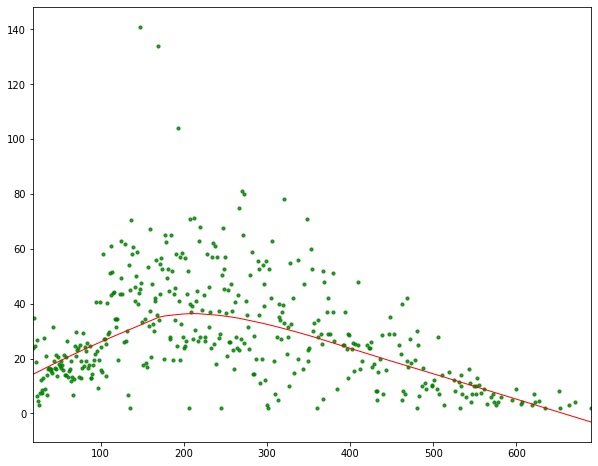

In [13]:
key_ls = []
val_ls = []

for k, v in avgs_dt.items():
    v = [i for i in v if i >= min_count]
    if v:
        key_ls.append(k)
        val_ls.append(mean(v))

plt.figure(figsize=(10,8))
sns.regplot(key_ls, val_ls, color="green", scatter_kws={"s": 10},
             line_kws={"color":"r","alpha":1,"lw":1} ,lowess=True)
plt.show()

### histogram of read lengths

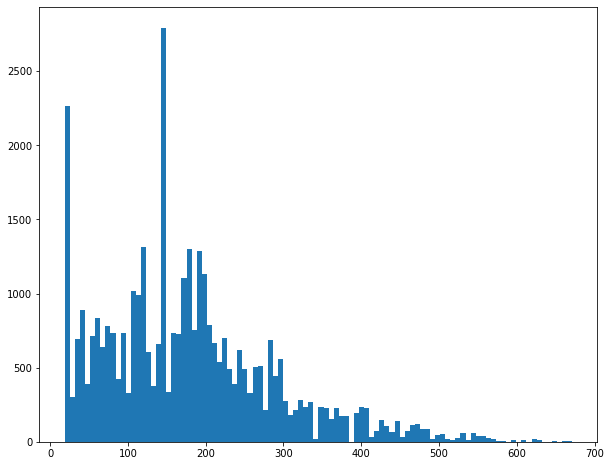

In [14]:
final_dt = final_df['abs_length'].value_counts().to_dict()

plt.figure(figsize=(10,8))
plt.hist(final_dt.keys(), weights=final_dt.values(), bins=100)
plt.show()

Write to file.

In [15]:
final_df.to_csv('snipen_GCA_000005845_corrected.csv', index=None)